In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Util functions to transform and visualize cells 

In [2]:
class Args:
    """
    Class to convert a dictionary into an object, allowing attribute-style access.

    Attributes:
        dictionary (dict): The dictionary to be converted into an object.
    """

    def __init__(self, dictionary):
        """
        Initializes the Args object with the provided dictionary.

        Parameters:
            dictionary (dict): The dictionary to be converted into an object.
        """
        self.__dict__ = dictionary

    def __getattr__(self, key):
        """
        Allows attribute-style access to dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.

        Raises:
            AttributeError: If the key does not exist in the dictionary.
        """
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        """
        Allows calling the object to retrieve dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.
        """
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    """
    Convert a PyTorch tensor to a NumPy array and normalize pixel values.

    Parameters:
        t (torch.Tensor): The PyTorch tensor to be converted.

    Returns:
        numpy.ndarray: The NumPy array representation of the tensor.
    """
    if not batch_dim:
        return ((t.permute(1, 2, 0) + 1) / 2).clamp(0, 1).cpu().numpy()
    else: 
        return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, size=((1.5, 1.5))):
    """
    Plot a specified number of images from a list of images.

    Parameters:
        images (list): A list containing image data.
        n_to_plot (int): The number of images to plot.
        size (tuple): The size of each plot (optional).

    Returns:
        None
    """
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        plt.imshow(img)
        plt.show()
        if i == n_to_plot:
            break

def euclidean_distance(A, B):
    """
    Compute the Euclidean distance between all pairs of rows of matrices A and B.
    
    Args:
    - A: torch.Tensor of shape (m, d)
    - B: torch.Tensor of shape (n, d)
    
    Returns:
    - distances: torch.Tensor of shape (m, n) containing the Euclidean distances between all pairs of rows of A and B
    """
    # Compute squared Euclidean distances
    A_square = torch.sum(A**2, dim=1, keepdim=True)  # Shape: (m, 1)
    B_square = torch.sum(B**2, dim=1)  # Shape: (n,)
    AB_dot = torch.matmul(A, B.t())  # Shape: (m, n)
    distances_square = A_square - 2 * AB_dot + B_square  # Shape: (m, n)
    
    # Take the square root to get the Euclidean distances
    distances = torch.sqrt(distances_square)
    
    return distances

In [3]:
config_params = {
    # TASK NAME
    "task_name": "bbbc021_all_retrain",

    # IMAGE
    "img_size": 96,
    "latent_dim": 160,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 16,
    "dim_in": 64,

    # LOSS
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,

    # TRAINING
    "total_epochs": 150,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": ["docetaxel", "AZ841", "cytochalasin D", "simvastatin", "cyclohexamide", "latrunculin B", "epothilone B", "lactacystin"],
    "mol_list": None,
    "balanced": False,
    "trainable_emb": False,
    "dataset_name": "bbbc021",
    "n_channels": 3,
    "num_workers": 6,
    "seed": 42,

    # DIRECTORIES FOR DATA
    "image_path": "../../../project_folder/datasets/bbbc021_all",
    "data_index_path": "../../../project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv",
    "embedding_path": "../../../embeddings/csv/emb_rdkit.csv",

    # DIRECTORIES FOR RESULTS
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",  # Name of directory for sampled images
    "checkpoint_dir": "checkpoint",  # Name of directory for checkpoints
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "",

    # DATA HANDLEMENT
    "augment_train": True,
    "normalize": True,

    # LOGGING INFO
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,

    # PARAMETERS FOR CONDITION ENCODING
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,

    # Lightning
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "bbbc021",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}


args = OmegaConf.create(config_params)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240205_347bc76f-e679-42e6-91b7-8fa5482b6474_bbbc021_all_retrain"

Initialize dataloader 

In [4]:
dataloader = CellDataLoader(args)

Initialize solver

In [5]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(150)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 14329472
Number of parameters in discriminator: 14309978
Number of parameters in mapping_network: 11328
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(26, 160)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

Initialize data loaders

In [6]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

## Read data loader from memory

In [7]:
data_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv", index_col=0)
image_path = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all")

In [8]:
def measure_dose_correlation_curves(data_index, dataloader, drug, weeks_to_keep, model):
    cpd_id = dataloader.mol2id[drug]
    images_dosages = {}
    images_controls = []
    styles_controls = []
    for batch in tqdm(dataloader.train_dataloader()):
        # Weeks controls
        weeks_ctr = np.array([week.split("_")[0] for week in batch["file_names"][0]])

        # Only keep the weeks of interests from the batch 
        X_ctr = batch["X"][0]
        X_ctr_filtered = X_ctr[np.isin(weeks_ctr, weeks_to_keep)]
        images_controls.append(X_ctr_filtered)
        if len(X_ctr_filtered) > 0:
            with torch.no_grad():
                styles_controls.append(model.style_encoder(X_ctr_filtered))

        # Only keep the left out drug 
        cpd = batch["mol_one_hot"].argmax(1)
        mask = cpd==cpd_id
    
        X_drugs = batch["X"][1][mask]    
        dose =  batch["dose"][mask]   
        for d in dose:
            d = d.item()
            if d not in images_dosages:
                images_dosages[d] = []
            dose_mask = dose == d
            images_dosages[d].append(X_drugs[dose_mask])
    return {key:torch.cat(val, dim=0) for key, val in images_dosages.items()}, torch.cat(images_controls, dim=0), torch.cat(styles_controls, dim=0)

## Check available drugs

In [9]:
dataloader.mol2id

{'ALLN': 0,
 'AZ138': 1,
 'AZ258': 2,
 'MG-132': 3,
 'PD-169316': 4,
 'PP-2': 5,
 'alsterpaullone': 6,
 'anisomycin': 7,
 'bryostatin': 8,
 'camptothecin': 9,
 'chlorambucil': 10,
 'cisplatin': 11,
 'colchicine': 12,
 'cytochalasin B': 13,
 'demecolcine': 14,
 'emetine': 15,
 'etoposide': 16,
 'floxuridine': 17,
 'methotrexate': 18,
 'mevinolin/lovastatin': 19,
 'mitomycin C': 20,
 'mitoxantrone': 21,
 'nocodazole': 22,
 'proteasome inhibitor I': 23,
 'taxol': 24,
 'vincristine': 25}

**Cytochalasin B**

In [10]:
weeks_cyto = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="cytochalasin B"].BATCH]))

In [11]:
images_dosages_cyto, images_controls_cyto, style_controls_cyto = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "cytochalasin B", 
                                                                                            weeks_cyto, 
                                                                                            solver)

100%|██████████| 194/194 [00:40<00:00,  4.77it/s]


30.0 



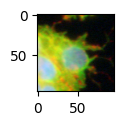

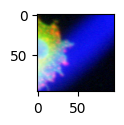

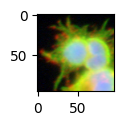

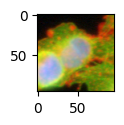

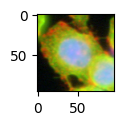

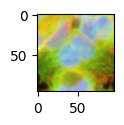

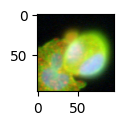

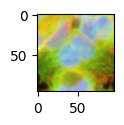

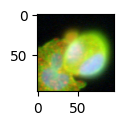

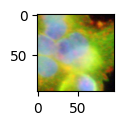

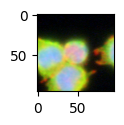

10.0 



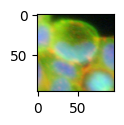

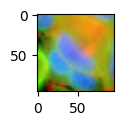

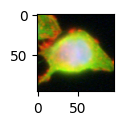

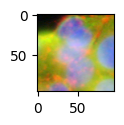

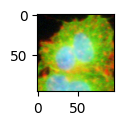

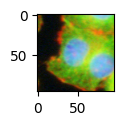

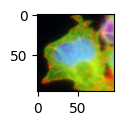

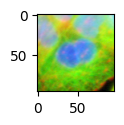

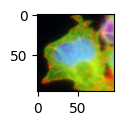

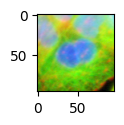

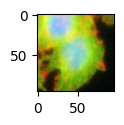

In [12]:
for id in images_dosages_cyto:
    print(id,"\n")
    for i, im in enumerate(images_dosages_cyto[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

**vincristine**

In [13]:
weeks_cyto = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="vincristine"].BATCH]))

In [14]:
images_dosages_vincristine, images_controls_vincristine, style_controls_vincristine = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "vincristine", 
                                                                                            weeks_cyto, 
                                                                                            solver)

100%|██████████| 194/194 [00:18<00:00, 10.43it/s]


0.01 



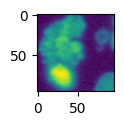

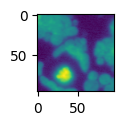

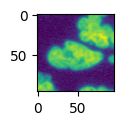

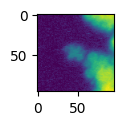

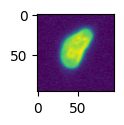

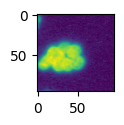

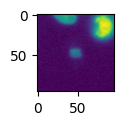

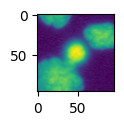

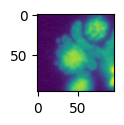

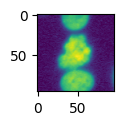

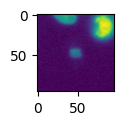

1.0 



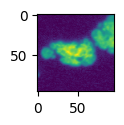

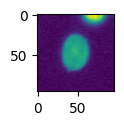

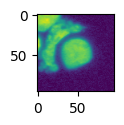

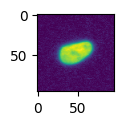

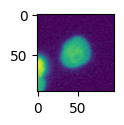

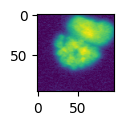

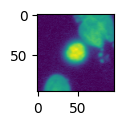

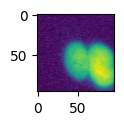

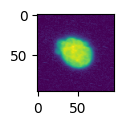

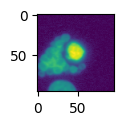

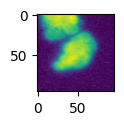

0.1 



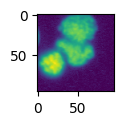

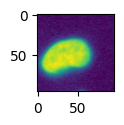

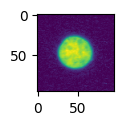

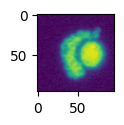

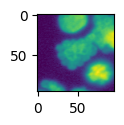

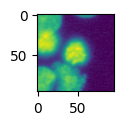

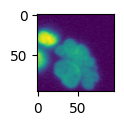

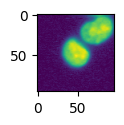

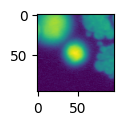

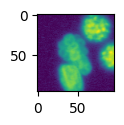

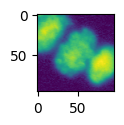

0.003 



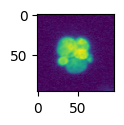

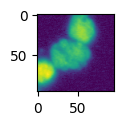

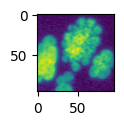

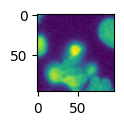

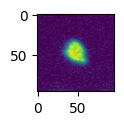

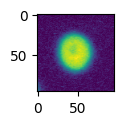

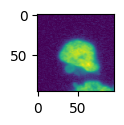

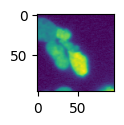

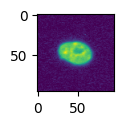

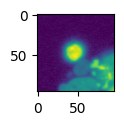

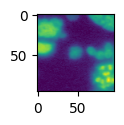

3.0 



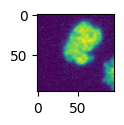

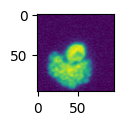

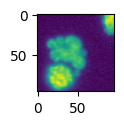

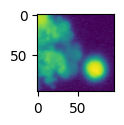

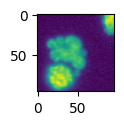

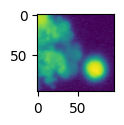

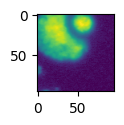

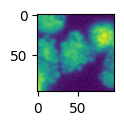

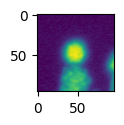

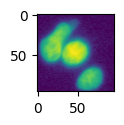

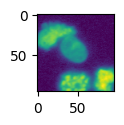

0.3 



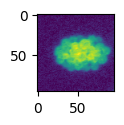

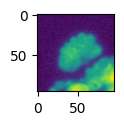

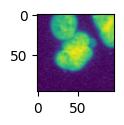

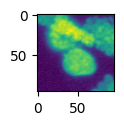

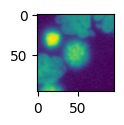

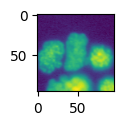

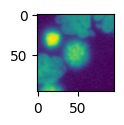

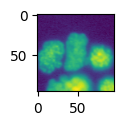

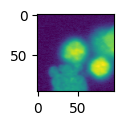

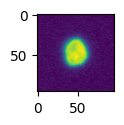

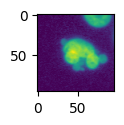

0.03 



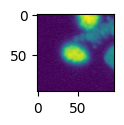

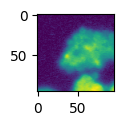

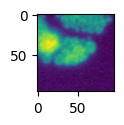

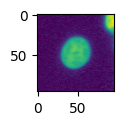

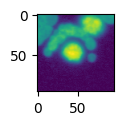

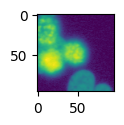

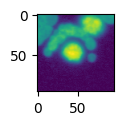

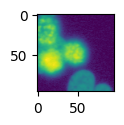

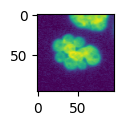

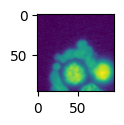

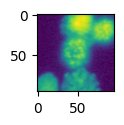

In [28]:
for id in images_dosages_vincristine:
    print(id,"\n")
    for i, im in enumerate(images_dosages_vincristine[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np[:,:,2])
        plt.show()
        if i == 10:
            break

**taxol**

In [16]:
weeks_taxol = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="taxol"].BATCH]))

In [17]:
images_dosages_taxol, images_controls_taxol, style_controls_taxol = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "taxol", 
                                                                                            weeks_taxol, 
                                                                                            solver)

100%|██████████| 194/194 [00:17<00:00, 11.39it/s]


1.0 



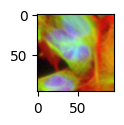

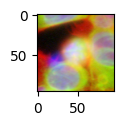

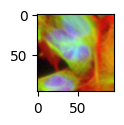

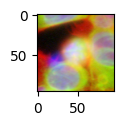

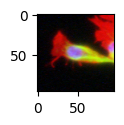

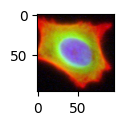

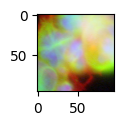

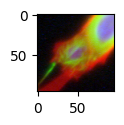

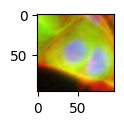

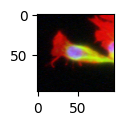

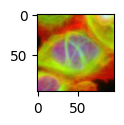

3.0 



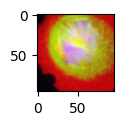

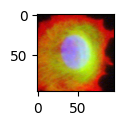

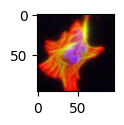

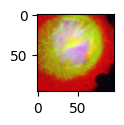

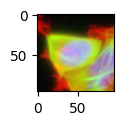

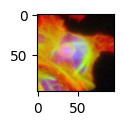

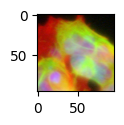

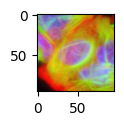

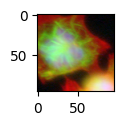

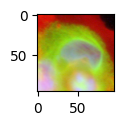

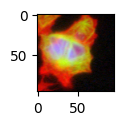

0.3 



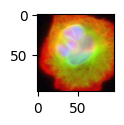

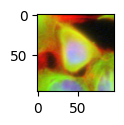

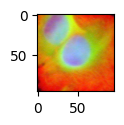

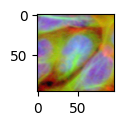

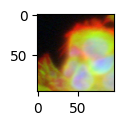

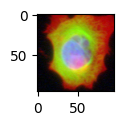

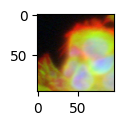

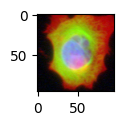

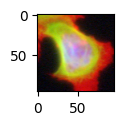

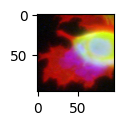

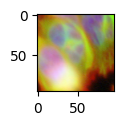

In [18]:
for id in images_dosages_taxol:
    print(id,"\n")
    for i, im in enumerate(images_dosages_taxol[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

AZ138

100%|██████████| 194/194 [00:17<00:00, 11.04it/s]


0.1 



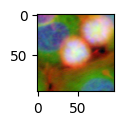

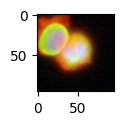

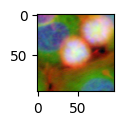

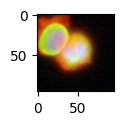

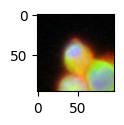

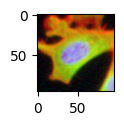

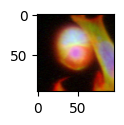

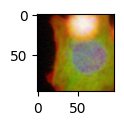

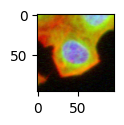

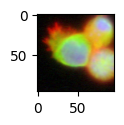

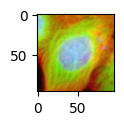

3.0 



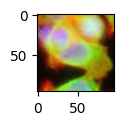

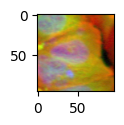

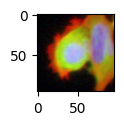

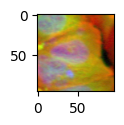

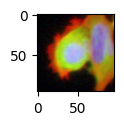

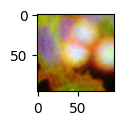

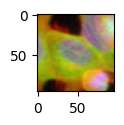

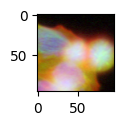

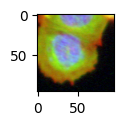

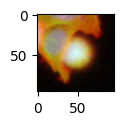

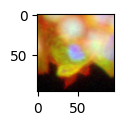

0.3 



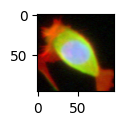

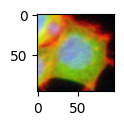

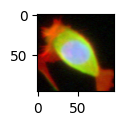

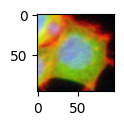

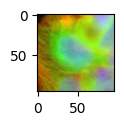

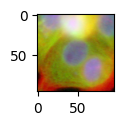

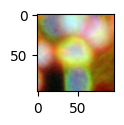

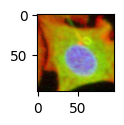

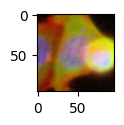

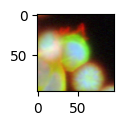

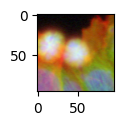

0.03 



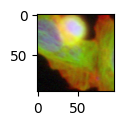

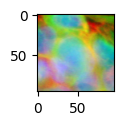

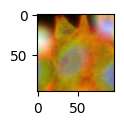

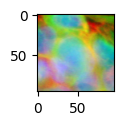

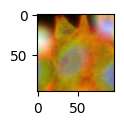

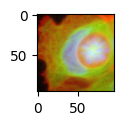

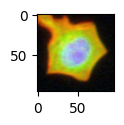

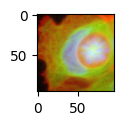

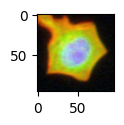

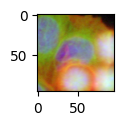

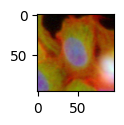

1.0 



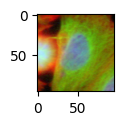

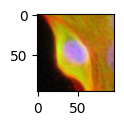

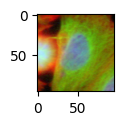

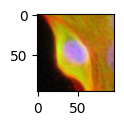

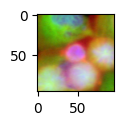

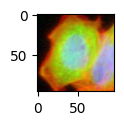

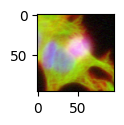

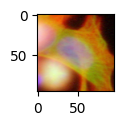

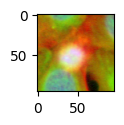

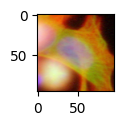

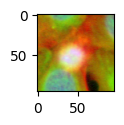

In [19]:
weeks_AZ138 = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="AZ138"].BATCH]))

images_dosages_AZ138, images_controls_taxol, style_controls_AZ138 = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "AZ138", 
                                                                                            weeks_AZ138, 
                                                                                            solver)
for id in images_dosages_AZ138:
    print(id,"\n")
    for i, im in enumerate(images_dosages_AZ138[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

AZ258

100%|██████████| 194/194 [00:16<00:00, 11.52it/s]


0.3 



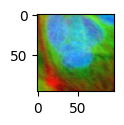

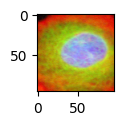

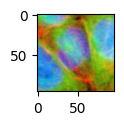

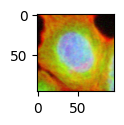

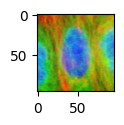

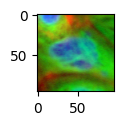

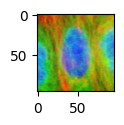

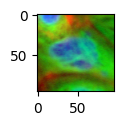

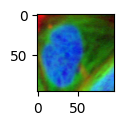

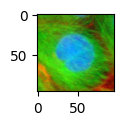

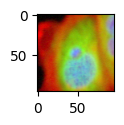

0.1 



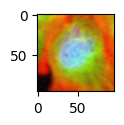

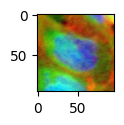

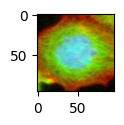

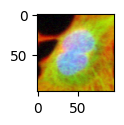

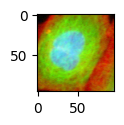

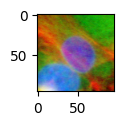

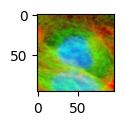

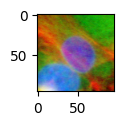

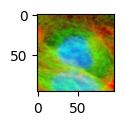

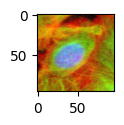

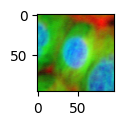

1.0 



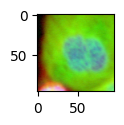

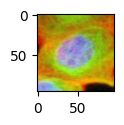

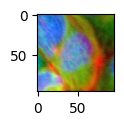

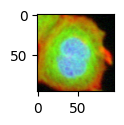

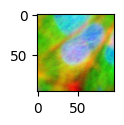

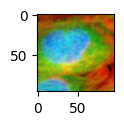

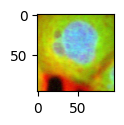

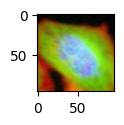

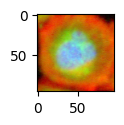

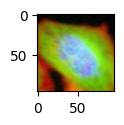

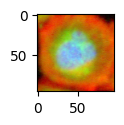

In [20]:
weeks_AZ258 = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="AZ258"].BATCH]))

images_dosages_AZ258, images_controls_AZ258, style_controls_AZ258 = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "AZ258", 
                                                                                            weeks_AZ258, 
                                                                                            solver)
for id in images_dosages_AZ258:
    print(id,"\n")
    for i, im in enumerate(images_dosages_AZ258[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

PP-2

100%|██████████| 194/194 [00:14<00:00, 13.13it/s]


10.0 



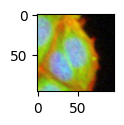

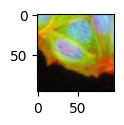

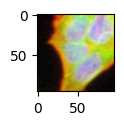

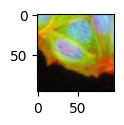

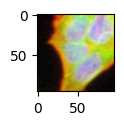

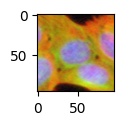

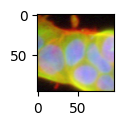

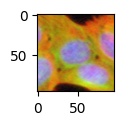

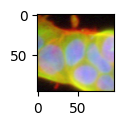

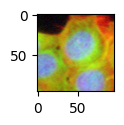

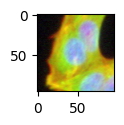

3.0 



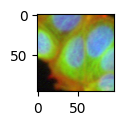

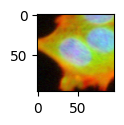

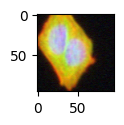

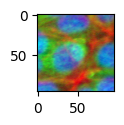

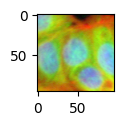

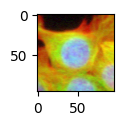

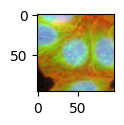

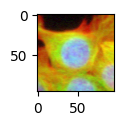

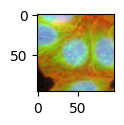

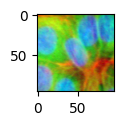

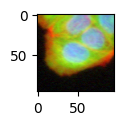

In [21]:
weeks_PP2 = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="PP-2"].BATCH]))

images_dosages_PP2, images_controls_PP2, style_controls_PP2 = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "PP-2", 
                                                                                            weeks_PP2, 
                                                                                            solver)
for id in images_dosages_PP2:
    print(id,"\n")
    for i, im in enumerate(images_dosages_PP2[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

Cholicine

100%|██████████| 194/194 [00:14<00:00, 13.19it/s]


0.03 



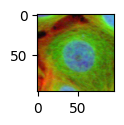

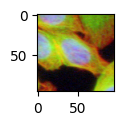

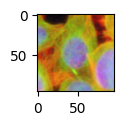

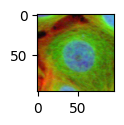

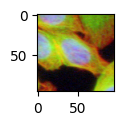

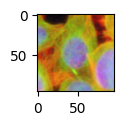

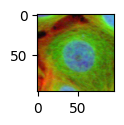

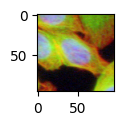

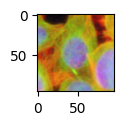

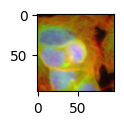

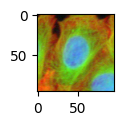

In [22]:
weeks_colchicine = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="colchicine"].BATCH]))

images_dosages_colchicine, images_controls_colchicine, style_controls_colchicine = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "colchicine", 
                                                                                            weeks_colchicine, 
                                                                                            solver)
for id in images_dosages_colchicine:
    print(id,"\n")
    for i, im in enumerate(images_dosages_colchicine[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

Demecolcine

100%|██████████| 194/194 [00:14<00:00, 13.29it/s]


0.3 



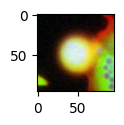

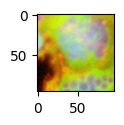

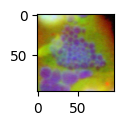

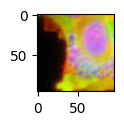

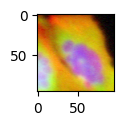

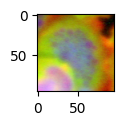

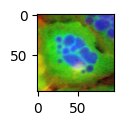

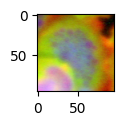

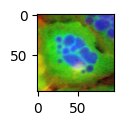

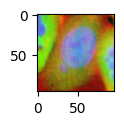

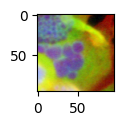

3.0 



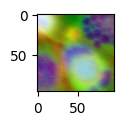

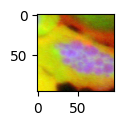

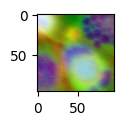

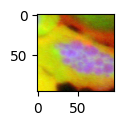

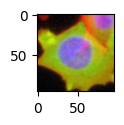

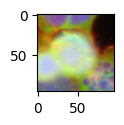

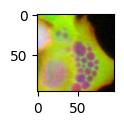

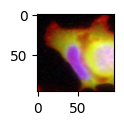

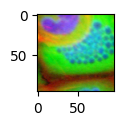

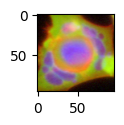

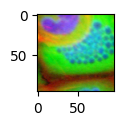

10.0 



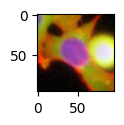

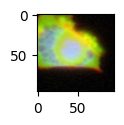

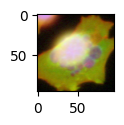

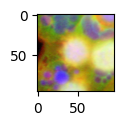

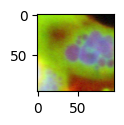

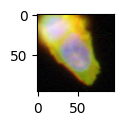

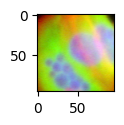

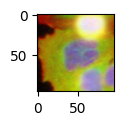

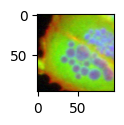

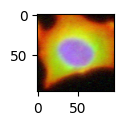

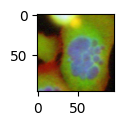

1.0 



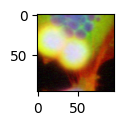

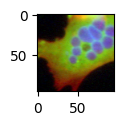

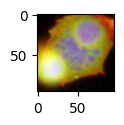

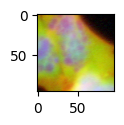

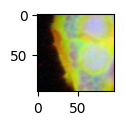

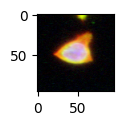

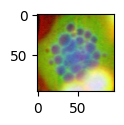

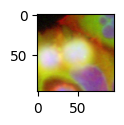

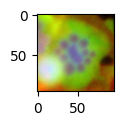

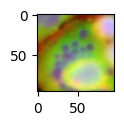

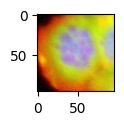

In [23]:
weeks_demecolcine = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="demecolcine"].BATCH]))

images_dosages_demecolcine, images_controls_demecolcine, style_controls_demecolcine = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "demecolcine", 
                                                                                            weeks_demecolcine, 
                                                                                            solver)
for id in images_dosages_demecolcine:
    print(id,"\n")
    for i, im in enumerate(images_dosages_demecolcine[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

mevinolin/lovastatin

100%|██████████| 194/194 [00:13<00:00, 14.28it/s]


5.0 



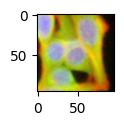

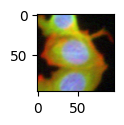

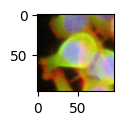

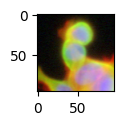

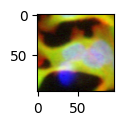

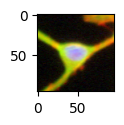

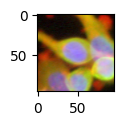

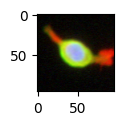

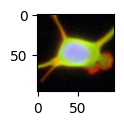

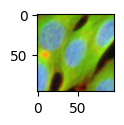

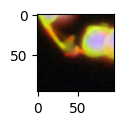

15.0 



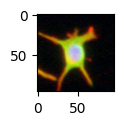

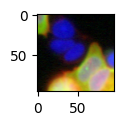

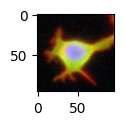

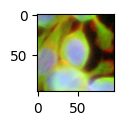

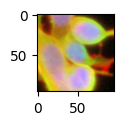

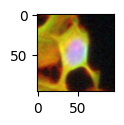

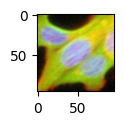

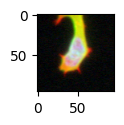

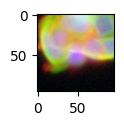

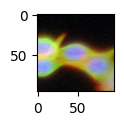

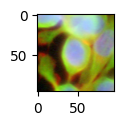

1.5 



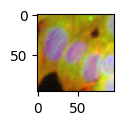

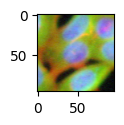

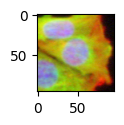

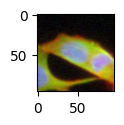

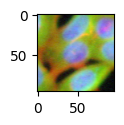

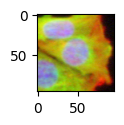

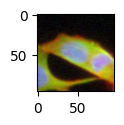

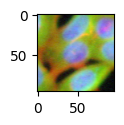

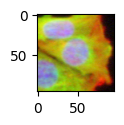

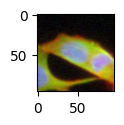

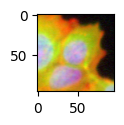

In [24]:
weeks_mevin = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mevinolin/lovastatin"].BATCH]))

images_dosages_mevin, images_controls_mevin, style_controls_mevin = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "mevinolin/lovastatin", 
                                                                                            weeks_mevin, 
                                                                                            solver)
for id in images_dosages_mevin:
    print(id,"\n")
    for i, im in enumerate(images_dosages_mevin[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

mitomycin C

100%|██████████| 194/194 [00:15<00:00, 12.21it/s]


0.3 



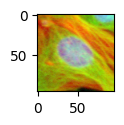

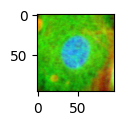

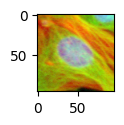

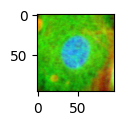

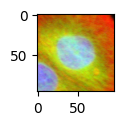

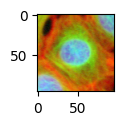

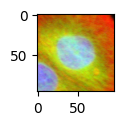

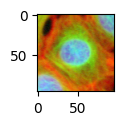

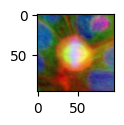

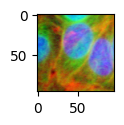

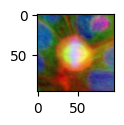

0.1 



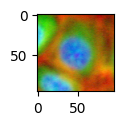

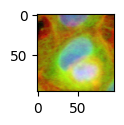

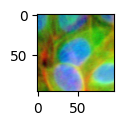

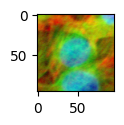

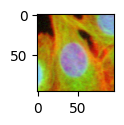

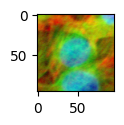

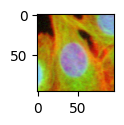

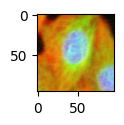

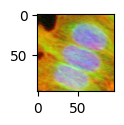

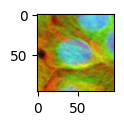

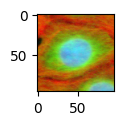

3.0 



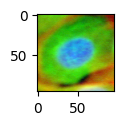

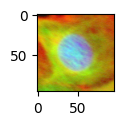

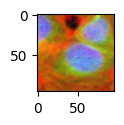

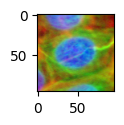

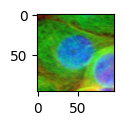

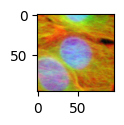

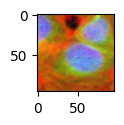

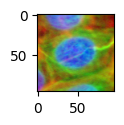

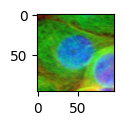

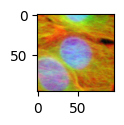

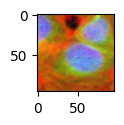

1.0 



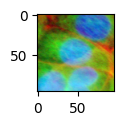

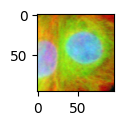

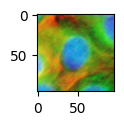

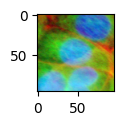

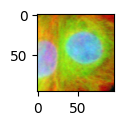

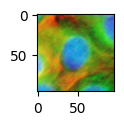

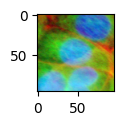

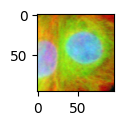

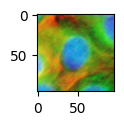

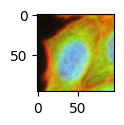

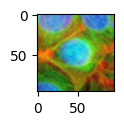

In [25]:
weeks_mito = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mitomycin C"].BATCH]))

images_dosages_mito, images_controls_mito, style_controls_mito = measure_dose_correlation_curves(data_index, 
                                                                                                    dataloader, 
                                                                                                    "mitomycin C", 
                                                                                                    weeks_mito, 
                                                                                                    solver)
for id in images_dosages_mito:
    print(id,"\n")
    for i, im in enumerate(images_dosages_mito[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

mitoxantrone

100%|██████████| 194/194 [00:13<00:00, 14.61it/s]


0.01 



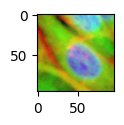

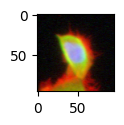

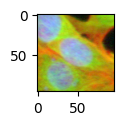

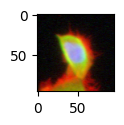

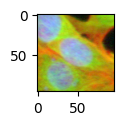

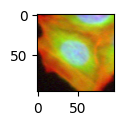

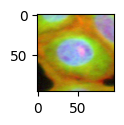

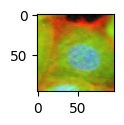

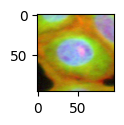

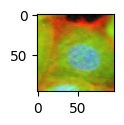

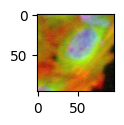

0.003 



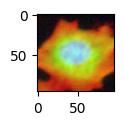

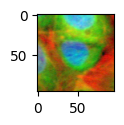

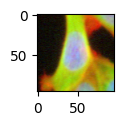

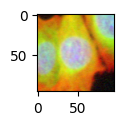

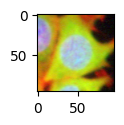

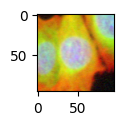

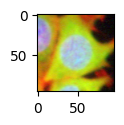

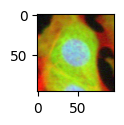

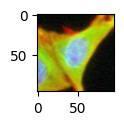

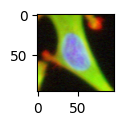

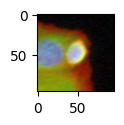

In [26]:
weeks_mitox = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mitoxantrone"].BATCH]))

images_dosages_mitox, images_controls_mitox, style_controls_mitox = measure_dose_correlation_curves(data_index, 
                                                                                                    dataloader, 
                                                                                                    "mitoxantrone", 
                                                                                                    weeks_mitox, 
                                                                                                    solver)
for id in images_dosages_mitox:
    print(id,"\n")
    for i, im in enumerate(images_dosages_mitox[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break

proteasome inhibitor I

100%|██████████| 194/194 [00:13<00:00, 14.71it/s]


0.1 



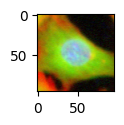

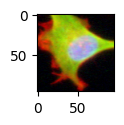

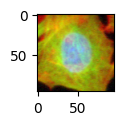

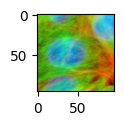

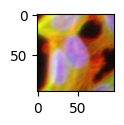

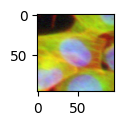

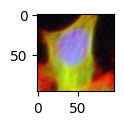

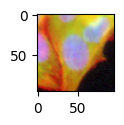

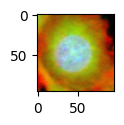

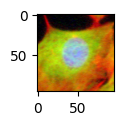

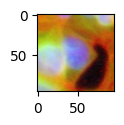

3.0 



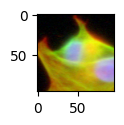

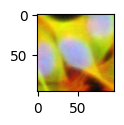

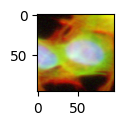

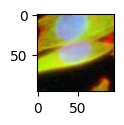

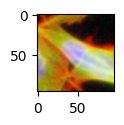

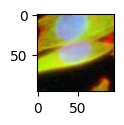

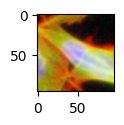

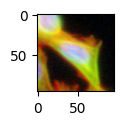

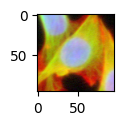

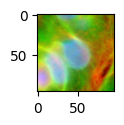

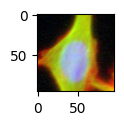

In [27]:
weeks_prote = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="proteasome inhibitor I"].BATCH]))

images_dosages_prote, images_controls_prote, style_controls_prote = measure_dose_correlation_curves(data_index, 
                                                                                                    dataloader, 
                                                                                                    "proteasome inhibitor I", 
                                                                                                    weeks_prote, 
                                                                                                    solver)
for id in images_dosages_prote:
    print(id,"\n")
    for i, im in enumerate(images_dosages_prote[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 10:
            break